In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [2]:
import keras 
import numpy as np
import librosa as lb
import sys
# import pandas as pd
from keras.utils import to_categorical
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import History 
from keras.utils import plot_model,to_categorical
from keras.optimizers import SGD
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct
# from iter_window import window 
import speechpy as sp
# import statistics
from keras import backend as K
from keras.layers import Dense, Activation, Flatten

Using TensorFlow backend.
/media/hinton/work2.7/local/lib/python2.7/site-packages/librosa/__init__.py:40: DeprecationWarning: You are using librosa with Python 2. Please note that librosa 0.7 will be the last version to support Python 2, after which it will require Python 3 or later.
  DeprecationWarning)


In [ ]:
filename = r'/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/DS_10283_853/protocol/CM_protocol/cm_train.trn'

# open the file for reading
filehandle = open(filename, 'r')
train_protocol = []
while True:
    # read a single line
    line = (filehandle.readline())
    train_protocol.append(line)
    if not line:
        break

# close the pointer to that file
filehandle.close()

In [ ]:
train_protocol1 = []
for i in train_protocol:
    i = i.replace('\n','')
    train_protocol1.append(i)

train_protocol = train_protocol1

train_pd = []
train_label = []
for i in train_protocol:
    j = i.split(' ')[1:2]
    train_pd.append(j)
    train_label.append(i.split(' ')[3:4])
    
train_pd1 = []
for i in train_pd:
    train_pd1.append(str(i)[2:-2])
train_pd = train_pd1
#import names of files in dataset
path = r'/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/DS_10283_853/wav/'
files = []
missing=[]
print(path)
for r, d, f in os.walk(path):
    for file in f:
        if '.wav' in file  :        
            files.append(os.path.join(r, file))
        else:
            missing.append(file)

#get train set
file_name=[]
for i in files:
    i = i.split('/')[-1].replace('.wav','')
    file_name.append(i)

file_set = set()
train_pd_set = set()

file_set = set(file_name)
train_pd_set = set(train_pd)

train_set = file_set & train_pd_set


## This code below ensures that train samples and train_labels are in the same order.

In [ ]:
train_label = []
label_set = []
for k in train_set:
    for i in train_protocol1:
        j = str(i.split(' ')[1:2])[2:-2]
        if j==k:
            label_set.append(j)
            train_label.append(i.split(' ')[3])
            
np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/train_label.npy",train_label)

In [ ]:
#To save audio data of trainset
train_audio= []
for count, i in enumerate(train_set):
#     print(i)
    j = i.split('_')[0]
    train_audio.append(lb.load('/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/DS_10283_853/wav/'+j+'/'+i+'.wav'))
    if count%1000==0 and count==1000:
        print('saving')
        np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/train"+str(count)+".npy",train_audio[0:count])
    elif count%1000==0 and count >= 1000:
        print('saving')
        np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/train"+str(count)+".npy",train_audio[count-1000:count])

In [ ]:
#To save audio data of trainset
from os import path
train_audio= []
missing_audio = []
for count, i in enumerate(train_set):
#     print(i)
    j = i.split('_')[0]
    if path.exists('/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/DS_10283_853/wav/'+j+'/'+i+'.wav'):
        train_audio.append(i)
    else:
        missing_audio.append(i)

train_set_list = list(train_set)


In [3]:
train = []
path = r'/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof'
print(path)
for r, d, f in os.walk(path):
    for file in f:
        if '.npy' in file and 'train' in file and '_' not in file:        
            train.append(np.load(os.path.join(r, file), allow_pickle = True))

/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof


In [4]:
train_format = []
for i in range(len(train)):
    for j in train[i]:
        train_format.append(j[0]) 

In [5]:
train_format= np.array(train_format)

In [6]:
def mfcc(signal,sample_rate,num_ceps):
    pre_emphasis = 0.97
    frame_size = 0.025
    frame_stride = 0.01
    nfilt = 20
    NFFT = 512
    emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = numpy.zeros((pad_signal_length - signal_length))
    pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(numpy.int32, copy=False)]
    frames *= numpy.hamming(frame_length)
    mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))
    low_freq_mel = 0
    high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)
    
    fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right
    
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = numpy.dot(pow_frames, fbank.T)
    filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * numpy.log10(filter_banks)  # dB
    mfcc = dct(filter_banks, type=2, axis=1,n=num_ceps, norm='ortho') # Keep 2-13
    return mfcc

In [7]:
train_format

array([array([0.00518005, 0.00855558, 0.00872142, ..., 0.0166531 , 0.01941423,
       0.01267171], dtype=float32),
       array([0.00518005, 0.00855558, 0.00872142, ..., 0.0166531 , 0.01941423,
       0.01267171], dtype=float32),
       array([ 3.3979668e-05,  1.0489402e-05, -1.3290052e-05, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32),
       ...,
       array([ 3.5302266e-05,  1.2031535e-05, -1.8286635e-05, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32),
       array([ 0.00175725,  0.00295675,  0.00311183, ..., -0.00148554,
       -0.00188394, -0.00127425], dtype=float32),
       array([ 3.5922803e-05,  1.2215733e-05, -1.9171408e-05, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)],
      dtype=object)

In [8]:
delta = []
delta2 = []
value = []
mfcc_feat_train = []
shape = []

for count,f in enumerate(train_format):
    delta=np.array(lb.feature.delta(mfcc(f,16000, num_ceps=30)))
    delta2=np.array(lb.feature.delta(mfcc(f,16000, num_ceps=30), order=2))
    value = np.concatenate([delta,delta2], axis=1)
    print(value.shape,delta.shape,delta2.shape)
    shape = np.append(shape,(value.shape[0]))
#     mean_value = mean_value.append(sp.processing.cmvnw(value))
    if count%100==0:
        print(count)

# padded_value =pad_sequences(value,maxlen=17880,dtype='float32')
# mfcc_feat_train[count] = value
    

((431, 60), (431, 30), (431, 30))
0
((431, 60), (431, 30), (431, 30))
((489, 60), (489, 30), (489, 30))
((474, 60), (474, 30), (474, 30))
((672, 60), (672, 30), (672, 30))
((672, 60), (672, 30), (672, 30))
((671, 60), (671, 30), (671, 30))
((431, 60), (431, 30), (431, 30))
((447, 60), (447, 30), (447, 30))
((760, 60), (760, 30), (760, 30))
((261, 60), (261, 30), (261, 30))
((431, 60), (431, 30), (431, 30))
((492, 60), (492, 30), (492, 30))
((760, 60), (760, 30), (760, 30))
((285, 60), (285, 30), (285, 30))
((371, 60), (371, 30), (371, 30))
((312, 60), (312, 30), (312, 30))
((348, 60), (348, 30), (348, 30))
((371, 60), (371, 30), (371, 30))
((371, 60), (371, 30), (371, 30))
((395, 60), (395, 30), (395, 30))
((642, 60), (642, 30), (642, 30))
((396, 60), (396, 30), (396, 30))
((462, 60), (462, 30), (462, 30))
((520, 60), (520, 30), (520, 30))
((349, 60), (349, 30), (349, 30))
((304, 60), (304, 30), (304, 30))
((484, 60), (484, 30), (484, 30))
((484, 60), (484, 30), (484, 30))
((483, 60), 

((570, 60), (570, 30), (570, 30))
((708, 60), (708, 30), (708, 30))
((478, 60), (478, 30), (478, 30))
((478, 60), (478, 30), (478, 30))
((396, 60), (396, 30), (396, 30))
((408, 60), (408, 30), (408, 30))
((708, 60), (708, 30), (708, 30))
((706, 60), (706, 30), (706, 30))
((577, 60), (577, 30), (577, 30))
((537, 60), (537, 30), (537, 30))
((578, 60), (578, 30), (578, 30))
((578, 60), (578, 30), (578, 30))
((596, 60), (596, 30), (596, 30))
((306, 60), (306, 30), (306, 30))
((320, 60), (320, 30), (320, 30))
((327, 60), (327, 30), (327, 30))
((595, 60), (595, 30), (595, 30))
((596, 60), (596, 30), (596, 30))
((418, 60), (418, 30), (418, 30))
((496, 60), (496, 30), (496, 30))
((496, 60), (496, 30), (496, 30))
((496, 60), (496, 30), (496, 30))
((319, 60), (319, 30), (319, 30))
((624, 60), (624, 30), (624, 30))
((566, 60), (566, 30), (566, 30))
((566, 60), (566, 30), (566, 30))
((299, 60), (299, 30), (299, 30))
((566, 60), (566, 30), (566, 30))
((530, 60), (530, 30), (530, 30))
((531, 60), (5

((551, 60), (551, 30), (551, 30))
((778, 60), (778, 30), (778, 30))
((778, 60), (778, 30), (778, 30))
((519, 60), (519, 30), (519, 30))
((777, 60), (777, 30), (777, 30))
((328, 60), (328, 30), (328, 30))
((467, 60), (467, 30), (467, 30))
((336, 60), (336, 30), (336, 30))
((407, 60), (407, 30), (407, 30))
((531, 60), (531, 30), (531, 30))
((411, 60), (411, 30), (411, 30))
((531, 60), (531, 30), (531, 30))
((531, 60), (531, 30), (531, 30))
((416, 60), (416, 30), (416, 30))
((419, 60), (419, 30), (419, 30))
((467, 60), (467, 30), (467, 30))
((467, 60), (467, 30), (467, 30))
((467, 60), (467, 30), (467, 30))
500
((490, 60), (490, 30), (490, 30))
((457, 60), (457, 30), (457, 30))
((357, 60), (357, 30), (357, 30))
((467, 60), (467, 30), (467, 30))
((457, 60), (457, 30), (457, 30))
((492, 60), (492, 30), (492, 30))
((498, 60), (498, 30), (498, 30))
((422, 60), (422, 30), (422, 30))
((369, 60), (369, 30), (369, 30))
((275, 60), (275, 30), (275, 30))
((398, 60), (398, 30), (398, 30))
((445, 60)

((666, 60), (666, 30), (666, 30))
((586, 60), (586, 30), (586, 30))
((463, 60), (463, 30), (463, 30))
((602, 60), (602, 30), (602, 30))
((585, 60), (585, 30), (585, 30))
((666, 60), (666, 30), (666, 30))
((665, 60), (665, 30), (665, 30))
((901, 60), (901, 30), (901, 30))
((184, 60), (184, 30), (184, 30))
((422, 60), (422, 30), (422, 30))
((292, 60), (292, 30), (292, 30))
((501, 60), (501, 30), (501, 30))
((699, 60), (699, 30), (699, 30))
((502, 60), (502, 30), (502, 30))
((502, 60), (502, 30), (502, 30))
((448, 60), (448, 30), (448, 30))
((465, 60), (465, 30), (465, 30))
((496, 60), (496, 30), (496, 30))
((496, 60), (496, 30), (496, 30))
((415, 60), (415, 30), (415, 30))
((496, 60), (496, 30), (496, 30))
((303, 60), (303, 30), (303, 30))
((304, 60), (304, 30), (304, 30))
((355, 60), (355, 30), (355, 30))
((355, 60), (355, 30), (355, 30))
((321, 60), (321, 30), (321, 30))
((354, 60), (354, 30), (354, 30))
((410, 60), (410, 30), (410, 30))
((349, 60), (349, 30), (349, 30))
((490, 60), (4

((602, 60), (602, 30), (602, 30))
((475, 60), (475, 30), (475, 30))
((392, 60), (392, 30), (392, 30))
((269, 60), (269, 30), (269, 30))
((369, 60), (369, 30), (369, 30))
((598, 60), (598, 30), (598, 30))
((457, 60), (457, 30), (457, 30))
((304, 60), (304, 30), (304, 30))
((351, 60), (351, 30), (351, 30))
((363, 60), (363, 30), (363, 30))
((380, 60), (380, 30), (380, 30))
((778, 60), (778, 30), (778, 30))
((514, 60), (514, 30), (514, 30))
((778, 60), (778, 30), (778, 30))
((778, 60), (778, 30), (778, 30))
((613, 60), (613, 30), (613, 30))
((591, 60), (591, 30), (591, 30))
((819, 60), (819, 30), (819, 30))
((819, 60), (819, 30), (819, 30))
((309, 60), (309, 30), (309, 30))
1000
((410, 60), (410, 30), (410, 30))
((789, 60), (789, 30), (789, 30))
((490, 60), (490, 30), (490, 30))
((790, 60), (790, 30), (790, 30))
((790, 60), (790, 30), (790, 30))
((479, 60), (479, 30), (479, 30))
((470, 60), (470, 30), (470, 30))
((613, 60), (613, 30), (613, 30))
((613, 60), (613, 30), (613, 30))
((339, 60

((512, 60), (512, 30), (512, 30))
((598, 60), (598, 30), (598, 30))
((522, 60), (522, 30), (522, 30))
((451, 60), (451, 30), (451, 30))
((516, 60), (516, 30), (516, 30))
((566, 60), (566, 30), (566, 30))
((340, 60), (340, 30), (340, 30))
((451, 60), (451, 30), (451, 30))
((351, 60), (351, 30), (351, 30))
((283, 60), (283, 30), (283, 30))
((283, 60), (283, 30), (283, 30))
((566, 60), (566, 30), (566, 30))
((379, 60), (379, 30), (379, 30))
((343, 60), (343, 30), (343, 30))
((535, 60), (535, 30), (535, 30))
((475, 60), (475, 30), (475, 30))
((498, 60), (498, 30), (498, 30))
((407, 60), (407, 30), (407, 30))
((713, 60), (713, 30), (713, 30))
((505, 60), (505, 30), (505, 30))
((713, 60), (713, 30), (713, 30))
((407, 60), (407, 30), (407, 30))
((596, 60), (596, 30), (596, 30))
((596, 60), (596, 30), (596, 30))
((515, 60), (515, 30), (515, 30))
((595, 60), (595, 30), (595, 30))
((713, 60), (713, 30), (713, 30))
((713, 60), (713, 30), (713, 30))
((538, 60), (538, 30), (538, 30))
((520, 60), (5

((410, 60), (410, 30), (410, 30))
((695, 60), (695, 30), (695, 30))
((695, 60), (695, 30), (695, 30))
((604, 60), (604, 30), (604, 30))
((595, 60), (595, 30), (595, 30))
((766, 60), (766, 30), (766, 30))
((766, 60), (766, 30), (766, 30))
((221, 60), (221, 30), (221, 30))
((766, 60), (766, 30), (766, 30))
((337, 60), (337, 30), (337, 30))
((695, 60), (695, 30), (695, 30))
((533, 60), (533, 30), (533, 30))
((569, 60), (569, 30), (569, 30))
((398, 60), (398, 30), (398, 30))
((395, 60), (395, 30), (395, 30))
((380, 60), (380, 30), (380, 30))
((380, 60), (380, 30), (380, 30))
((416, 60), (416, 30), (416, 30))
((267, 60), (267, 30), (267, 30))
((257, 60), (257, 30), (257, 30))
((267, 60), (267, 30), (267, 30))
((267, 60), (267, 30), (267, 30))
((445, 60), (445, 30), (445, 30))
((451, 60), (451, 30), (451, 30))
((360, 60), (360, 30), (360, 30))
((396, 60), (396, 30), (396, 30))
((389, 60), (389, 30), (389, 30))
((359, 60), (359, 30), (359, 30))
((618, 60), (618, 30), (618, 30))
((924, 60), (9

((708, 60), (708, 30), (708, 30))
((395, 60), (395, 30), (395, 30))
((354, 60), (354, 30), (354, 30))
((344, 60), (344, 30), (344, 30))
((708, 60), (708, 30), (708, 30))
((706, 60), (706, 30), (706, 30))
((577, 60), (577, 30), (577, 30))
((475, 60), (475, 30), (475, 30))
((578, 60), (578, 30), (578, 30))
((578, 60), (578, 30), (578, 30))
((364, 60), (364, 30), (364, 30))
((420, 60), (420, 30), (420, 30))
((343, 60), (343, 30), (343, 30))
((189, 60), (189, 30), (189, 30))
((310, 60), (310, 30), (310, 30))
((357, 60), (357, 30), (357, 30))
((316, 60), (316, 30), (316, 30))
((345, 60), (345, 30), (345, 30))
((422, 60), (422, 30), (422, 30))
((439, 60), (439, 30), (439, 30))
((428, 60), (428, 30), (428, 30))
((380, 60), (380, 30), (380, 30))
((428, 60), (428, 30), (428, 30))
((345, 60), (345, 30), (345, 30))
((416, 60), (416, 30), (416, 30))
((631, 60), (631, 30), (631, 30))
((631, 60), (631, 30), (631, 30))
((211, 60), (211, 30), (211, 30))
((631, 60), (631, 30), (631, 30))
((301, 60), (3

((490, 60), (490, 30), (490, 30))
((635, 60), (635, 30), (635, 30))
((489, 60), (489, 30), (489, 30))
((339, 60), (339, 30), (339, 30))
((472, 60), (472, 30), (472, 30))
((435, 60), (435, 30), (435, 30))
((435, 60), (435, 30), (435, 30))
((496, 60), (496, 30), (496, 30))
((620, 60), (620, 30), (620, 30))
((569, 60), (569, 30), (569, 30))
((675, 60), (675, 30), (675, 30))
((246, 60), (246, 30), (246, 30))
((345, 60), (345, 30), (345, 30))
((569, 60), (569, 30), (569, 30))
((351, 60), (351, 30), (351, 30))
((427, 60), (427, 30), (427, 30))
((251, 60), (251, 30), (251, 30))
((592, 60), (592, 30), (592, 30))
((281, 60), (281, 30), (281, 30))
((490, 60), (490, 30), (490, 30))
((490, 60), (490, 30), (490, 30))
((489, 60), (489, 30), (489, 30))
((441, 60), (441, 30), (441, 30))
((614, 60), (614, 30), (614, 30))
((613, 60), (613, 30), (613, 30))
((422, 60), (422, 30), (422, 30))
((434, 60), (434, 30), (434, 30))
((510, 60), (510, 30), (510, 30))
((445, 60), (445, 30), (445, 30))
((677, 60), (6

((498, 60), (498, 30), (498, 30))
((363, 60), (363, 30), (363, 30))
((381, 60), (381, 30), (381, 30))
((340, 60), (340, 30), (340, 30))
((345, 60), (345, 30), (345, 30))
((322, 60), (322, 30), (322, 30))
((763, 60), (763, 30), (763, 30))
((445, 60), (445, 30), (445, 30))
((411, 60), (411, 30), (411, 30))
((398, 60), (398, 30), (398, 30))
((569, 60), (569, 30), (569, 30))
((584, 60), (584, 30), (584, 30))
((603, 60), (603, 30), (603, 30))
((377, 60), (377, 30), (377, 30))
((478, 60), (478, 30), (478, 30))
((479, 60), (479, 30), (479, 30))
((479, 60), (479, 30), (479, 30))
((329, 60), (329, 30), (329, 30))
((309, 60), (309, 30), (309, 30))
((584, 60), (584, 30), (584, 30))
((584, 60), (584, 30), (584, 30))
((396, 60), (396, 30), (396, 30))
((298, 60), (298, 30), (298, 30))
((537, 60), (537, 30), (537, 30))
((535, 60), (535, 30), (535, 30))
((360, 60), (360, 30), (360, 30))
((356, 60), (356, 30), (356, 30))
((648, 60), (648, 30), (648, 30))
((648, 60), (648, 30), (648, 30))
((648, 60), (6

((902, 60), (902, 30), (902, 30))
((901, 60), (901, 30), (901, 30))
((180, 60), (180, 30), (180, 30))
((176, 60), (176, 30), (176, 30))
((607, 60), (607, 30), (607, 30))
((478, 60), (478, 30), (478, 30))
((902, 60), (902, 30), (902, 30))
((607, 60), (607, 30), (607, 30))
((535, 60), (535, 30), (535, 30))
((235, 60), (235, 30), (235, 30))
((443, 60), (443, 30), (443, 30))
((607, 60), (607, 30), (607, 30))
((555, 60), (555, 30), (555, 30))
((571, 60), (571, 30), (571, 30))
((726, 60), (726, 30), (726, 30))
((745, 60), (745, 30), (745, 30))
((724, 60), (724, 30), (724, 30))
((726, 60), (726, 30), (726, 30))
((483, 60), (483, 30), (483, 30))
((484, 60), (484, 30), (484, 30))
((573, 60), (573, 30), (573, 30))
((502, 60), (502, 30), (502, 30))
((338, 60), (338, 30), (338, 30))
((571, 60), (571, 30), (571, 30))
((493, 60), (493, 30), (493, 30))
((304, 60), (304, 30), (304, 30))
((681, 60), (681, 30), (681, 30))
((407, 60), (407, 30), (407, 30))
((557, 60), (557, 30), (557, 30))
((528, 60), (5

((695, 60), (695, 30), (695, 30))
((695, 60), (695, 30), (695, 30))
2700
((296, 60), (296, 30), (296, 30))
((402, 60), (402, 30), (402, 30))
((296, 60), (296, 30), (296, 30))
((346, 60), (346, 30), (346, 30))
((380, 60), (380, 30), (380, 30))
((451, 60), (451, 30), (451, 30))
((757, 60), (757, 30), (757, 30))
((386, 60), (386, 30), (386, 30))
((357, 60), (357, 30), (357, 30))
((516, 60), (516, 30), (516, 30))
((416, 60), (416, 30), (416, 30))
((569, 60), (569, 30), (569, 30))
((463, 60), (463, 30), (463, 30))
((204, 60), (204, 30), (204, 30))
((753, 60), (753, 30), (753, 30))
((666, 60), (666, 30), (666, 30))
((672, 60), (672, 30), (672, 30))
((460, 60), (460, 30), (460, 30))
((516, 60), (516, 30), (516, 30))
((924, 60), (924, 30), (924, 30))
((166, 60), (166, 30), (166, 30))
((706, 60), (706, 30), (706, 30))
((708, 60), (708, 30), (708, 30))
((924, 60), (924, 30), (924, 30))
((452, 60), (452, 30), (452, 30))
((452, 60), (452, 30), (452, 30))
((672, 60), (672, 30), (672, 30))
((672, 60

((386, 60), (386, 30), (386, 30))
((479, 60), (479, 30), (479, 30))
((348, 60), (348, 30), (348, 30))
((478, 60), (478, 30), (478, 30))
((434, 60), (434, 30), (434, 30))
((357, 60), (357, 30), (357, 30))
((692, 60), (692, 30), (692, 30))
((557, 60), (557, 30), (557, 30))
((645, 60), (645, 30), (645, 30))
((478, 60), (478, 30), (478, 30))
((422, 60), (422, 30), (422, 30))
((563, 60), (563, 30), (563, 30))
((665, 60), (665, 30), (665, 30))
((239, 60), (239, 30), (239, 30))
((792, 60), (792, 30), (792, 30))
((482, 60), (482, 30), (482, 30))
((365, 60), (365, 30), (365, 30))
((345, 60), (345, 30), (345, 30))
((431, 60), (431, 30), (431, 30))
((337, 60), (337, 30), (337, 30))
((553, 60), (553, 30), (553, 30))
((416, 60), (416, 30), (416, 30))
((580, 60), (580, 30), (580, 30))
((354, 60), (354, 30), (354, 30))
((355, 60), (355, 30), (355, 30))
((355, 60), (355, 30), (355, 30))
((278, 60), (278, 30), (278, 30))
((280, 60), (280, 30), (280, 30))
((431, 60), (431, 30), (431, 30))
((431, 60), (4

((346, 60), (346, 30), (346, 30))
((310, 60), (310, 30), (310, 30))
((333, 60), (333, 30), (333, 30))
((472, 60), (472, 30), (472, 30))
((316, 60), (316, 30), (316, 30))
((369, 60), (369, 30), (369, 30))
((304, 60), (304, 30), (304, 30))
((345, 60), (345, 30), (345, 30))
((645, 60), (645, 30), (645, 30))
((346, 60), (346, 30), (346, 30))
((212, 60), (212, 30), (212, 30))
3200
((445, 60), (445, 30), (445, 30))
((257, 60), (257, 30), (257, 30))
((375, 60), (375, 30), (375, 30))
((316, 60), (316, 30), (316, 30))
((357, 60), (357, 30), (357, 30))
((463, 60), (463, 30), (463, 30))
((228, 60), (228, 30), (228, 30))
((475, 60), (475, 30), (475, 30))
((360, 60), (360, 30), (360, 30))
((305, 60), (305, 30), (305, 30))
((378, 60), (378, 30), (378, 30))
((378, 60), (378, 30), (378, 30))
((337, 60), (337, 30), (337, 30))
((320, 60), (320, 30), (320, 30))
((360, 60), (360, 30), (360, 30))
((360, 60), (360, 30), (360, 30))
((349, 60), (349, 30), (349, 30))
((344, 60), (344, 30), (344, 30))
((496, 60

((226, 60), (226, 30), (226, 30))
((225, 60), (225, 30), (225, 30))
((478, 60), (478, 30), (478, 30))
((478, 60), (478, 30), (478, 30))
((648, 60), (648, 30), (648, 30))
((519, 60), (519, 30), (519, 30))
((519, 60), (519, 30), (519, 30))
((179, 60), (179, 30), (179, 30))
((519, 60), (519, 30), (519, 30))
((665, 60), (665, 30), (665, 30))
((666, 60), (666, 30), (666, 30))
((303, 60), (303, 30), (303, 30))
((318, 60), (318, 30), (318, 30))
((666, 60), (666, 30), (666, 30))
((406, 60), (406, 30), (406, 30))
((778, 60), (778, 30), (778, 30))
((454, 60), (454, 30), (454, 30))
((510, 60), (510, 30), (510, 30))
((537, 60), (537, 30), (537, 30))
((584, 60), (584, 30), (584, 30))
((530, 60), (530, 30), (530, 30))
((531, 60), (531, 30), (531, 30))
((531, 60), (531, 30), (531, 30))
((485, 60), (485, 30), (485, 30))
((485, 60), (485, 30), (485, 30))
((454, 60), (454, 30), (454, 30))
((454, 60), (454, 30), (454, 30))
((322, 60), (322, 30), (322, 30))
((474, 60), (474, 30), (474, 30))
((528, 60), (5

((410, 60), (410, 30), (410, 30))
((498, 60), (498, 30), (498, 30))
((475, 60), (475, 30), (475, 30))
((498, 60), (498, 30), (498, 30))
((545, 60), (545, 30), (545, 30))
((533, 60), (533, 30), (533, 30))
((557, 60), (557, 30), (557, 30))
((551, 60), (551, 30), (551, 30))
((334, 60), (334, 30), (334, 30))
((648, 60), (648, 30), (648, 30))
((384, 60), (384, 30), (384, 30))
((290, 60), (290, 30), (290, 30))
((384, 60), (384, 30), (384, 30))
((384, 60), (384, 30), (384, 30))
((245, 60), (245, 30), (245, 30))
((239, 60), (239, 30), (239, 30))
((648, 60), (648, 30), (648, 30))
((648, 60), (648, 30), (648, 30))
3700
((812, 60), (812, 30), (812, 30))
((812, 60), (812, 30), (812, 30))
((347, 60), (347, 30), (347, 30))
((501, 60), (501, 30), (501, 30))
((643, 60), (643, 30), (643, 30))
((643, 60), (643, 30), (643, 30))
((193, 60), (193, 30), (193, 30))
((642, 60), (642, 30), (642, 30))
((812, 60), (812, 30), (812, 30))
((463, 60), (463, 30), (463, 30))
((708, 60), (708, 30), (708, 30))
((708, 60

((209, 60), (209, 30), (209, 30))
((501, 60), (501, 30), (501, 30))
((501, 60), (501, 30), (501, 30))
((406, 60), (406, 30), (406, 30))
((414, 60), (414, 30), (414, 30))
((319, 60), (319, 30), (319, 30))
((319, 60), (319, 30), (319, 30))
((296, 60), (296, 30), (296, 30))
((671, 60), (671, 30), (671, 30))
((413, 60), (413, 30), (413, 30))
((549, 60), (549, 30), (549, 30))
((548, 60), (548, 30), (548, 30))
((293, 60), (293, 30), (293, 30))
((295, 60), (295, 30), (295, 30))
((496, 60), (496, 30), (496, 30))
((496, 60), (496, 30), (496, 30))
((496, 60), (496, 30), (496, 30))
((284, 60), (284, 30), (284, 30))
((411, 60), (411, 30), (411, 30))
((549, 60), (549, 30), (549, 30))
((431, 60), (431, 30), (431, 30))
((431, 60), (431, 30), (431, 30))
((558, 60), (558, 30), (558, 30))
((548, 60), (548, 30), (548, 30))
((672, 60), (672, 30), (672, 30))
((672, 60), (672, 30), (672, 30))
((457, 60), (457, 30), (457, 30))
((671, 60), (671, 30), (671, 30))
((487, 60), (487, 30), (487, 30))
((494, 60), (4

((581, 60), (581, 30), (581, 30))
((478, 60), (478, 30), (478, 30))
((410, 60), (410, 30), (410, 30))
((490, 60), (490, 30), (490, 30))
((403, 60), (403, 30), (403, 30))
((384, 60), (384, 30), (384, 30))
((760, 60), (760, 30), (760, 30))
((584, 60), (584, 30), (584, 30))
((584, 60), (584, 30), (584, 30))
((518, 60), (518, 30), (518, 30))
((584, 60), (584, 30), (584, 30))
((460, 60), (460, 30), (460, 30))
((461, 60), (461, 30), (461, 30))
((493, 60), (493, 30), (493, 30))
((488, 60), (488, 30), (488, 30))
((461, 60), (461, 30), (461, 30))
((500, 60), (500, 30), (500, 30))
((301, 60), (301, 30), (301, 30))
((562, 60), (562, 30), (562, 30))
((301, 60), (301, 30), (301, 30))
((301, 60), (301, 30), (301, 30))
((255, 60), (255, 30), (255, 30))
((248, 60), (248, 30), (248, 30))
((484, 60), (484, 30), (484, 30))
((483, 60), (483, 30), (483, 30))
((262, 60), (262, 30), (262, 30))
((484, 60), (484, 30), (484, 30))
((519, 60), (519, 30), (519, 30))
((291, 60), (291, 30), (291, 30))
((336, 60), (3

((535, 60), (535, 30), (535, 30))
((537, 60), (537, 30), (537, 30))
((616, 60), (616, 30), (616, 30))
((620, 60), (620, 30), (620, 30))
((924, 60), (924, 30), (924, 30))
((924, 60), (924, 30), (924, 30))
((188, 60), (188, 30), (188, 30))
((924, 60), (924, 30), (924, 30))
((584, 60), (584, 30), (584, 30))
((474, 60), (474, 30), (474, 30))
((472, 60), (472, 30), (472, 30))
((434, 60), (434, 30), (434, 30))
((434, 60), (434, 30), (434, 30))
((424, 60), (424, 30), (424, 30))
((613, 60), (613, 30), (613, 30))
((614, 60), (614, 30), (614, 30))
((348, 60), (348, 30), (348, 30))
((342, 60), (342, 30), (342, 30))
((490, 60), (490, 30), (490, 30))
((490, 60), (490, 30), (490, 30))
((358, 60), (358, 30), (358, 30))
((489, 60), (489, 30), (489, 30))
((503, 60), (503, 30), (503, 30))
((614, 60), (614, 30), (614, 30))
((568, 60), (568, 30), (568, 30))
((357, 60), (357, 30), (357, 30))
((510, 60), (510, 30), (510, 30))
((504, 60), (504, 30), (504, 30))
((386, 60), (386, 30), (386, 30))
((480, 60), (4

((665, 60), (665, 30), (665, 30))
((666, 60), (666, 30), (666, 30))
((602, 60), (602, 30), (602, 30))
((601, 60), (601, 30), (601, 30))
((902, 60), (902, 30), (902, 30))
((902, 60), (902, 30), (902, 30))
((181, 60), (181, 30), (181, 30))
((901, 60), (901, 30), (901, 30))
((578, 60), (578, 30), (578, 30))
((578, 60), (578, 30), (578, 30))
((578, 60), (578, 30), (578, 30))
((434, 60), (434, 30), (434, 30))
((573, 60), (573, 30), (573, 30))
((278, 60), (278, 30), (278, 30))
((666, 60), (666, 30), (666, 30))
((388, 60), (388, 30), (388, 30))
((335, 60), (335, 30), (335, 30))
((496, 60), (496, 30), (496, 30))
((621, 60), (621, 30), (621, 30))
((483, 60), (483, 30), (483, 30))
((446, 60), (446, 30), (446, 30))
((484, 60), (484, 30), (484, 30))
((484, 60), (484, 30), (484, 30))
((345, 60), (345, 30), (345, 30))
((338, 60), (338, 30), (338, 30))
((496, 60), (496, 30), (496, 30))
((496, 60), (496, 30), (496, 30))
((815, 60), (815, 30), (815, 30))
((422, 60), (422, 30), (422, 30))
((228, 60), (2

((330, 60), (330, 30), (330, 30))
((432, 60), (432, 30), (432, 30))
((478, 60), (478, 30), (478, 30))
((478, 60), (478, 30), (478, 30))
((478, 60), (478, 30), (478, 30))
((483, 60), (483, 30), (483, 30))
((496, 60), (496, 30), (496, 30))
((566, 60), (566, 30), (566, 30))
((566, 60), (566, 30), (566, 30))
((336, 60), (336, 30), (336, 30))
((358, 60), (358, 30), (358, 30))
((686, 60), (686, 30), (686, 30))
((522, 60), (522, 30), (522, 30))
((422, 60), (422, 30), (422, 30))
((375, 60), (375, 30), (375, 30))
((769, 60), (769, 30), (769, 30))
((387, 60), (387, 30), (387, 30))
((545, 60), (545, 30), (545, 30))
((633, 60), (633, 30), (633, 30))
((330, 60), (330, 30), (330, 30))
((735, 60), (735, 30), (735, 30))
((332, 60), (332, 30), (332, 30))
((332, 60), (332, 30), (332, 30))
((229, 60), (229, 30), (229, 30))
((228, 60), (228, 30), (228, 30))
((573, 60), (573, 30), (573, 30))
((527, 60), (527, 30), (527, 30))
((461, 60), (461, 30), (461, 30))
((302, 60), (302, 30), (302, 30))
((369, 60), (3

((389, 60), (389, 30), (389, 30))
((519, 60), (519, 30), (519, 30))
((519, 60), (519, 30), (519, 30))
((337, 60), (337, 30), (337, 30))
((690, 60), (690, 30), (690, 30))
((431, 60), (431, 30), (431, 30))
((431, 60), (431, 30), (431, 30))
((431, 60), (431, 30), (431, 30))
((277, 60), (277, 30), (277, 30))
((819, 60), (819, 30), (819, 30))
((371, 60), (371, 30), (371, 30))
((614, 60), (614, 30), (614, 30))
((392, 60), (392, 30), (392, 30))
((405, 60), (405, 30), (405, 30))
((467, 60), (467, 30), (467, 30))
((467, 60), (467, 30), (467, 30))
((390, 60), (390, 30), (390, 30))
((483, 60), (483, 30), (483, 30))
((484, 60), (484, 30), (484, 30))
((484, 60), (484, 30), (484, 30))
((508, 60), (508, 30), (508, 30))
((467, 60), (467, 30), (467, 30))
((360, 60), (360, 30), (360, 30))
((771, 60), (771, 30), (771, 30))
((773, 60), (773, 30), (773, 30))
((500, 60), (500, 30), (500, 30))
((504, 60), (504, 30), (504, 30))
((672, 60), (672, 30), (672, 30))
((672, 60), (672, 30), (672, 30))
((463, 60), (4

KeyboardInterrupt: 

In [13]:
1239*60

74340

In [22]:
delta = []
delta2 = []
value = []
mfcc_feat_train = np.empty((16000,74340))
shape = []
mean_value = []

for count,f in enumerate(train_format):
    delta=np.array(lb.feature.delta(mfcc(f,16000, num_ceps=30)))
    delta2=np.array(lb.feature.delta(mfcc(f,16000, num_ceps=30), order=2))
    value = np.concatenate([delta,delta2], axis=1)
#     print(value.shape,delta.shape,delta2.shape)
#     shape = np.append(shape,(value.shape[0]))
    mean_value = sp.processing.cmvnw(value).reshape(1,-1)
    padded_value =pad_sequences(mean_value,maxlen=74340,dtype='float32')
    mfcc_feat_train[count] = padded_value

    if count%100==0:
        print(count)

    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900


In [23]:
mfcc_feat_train.shape

(16000, 74340)

In [24]:
np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/mfcc_train_padded.npy",mfcc_feat_train,allow_pickle = True)

In [3]:
data_train = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/mfcc_train_padded.npy")

In [4]:
train_labels = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/train_label.npy")

train_labels=list(train_labels)

train_labels1 = list()
for i in train_labels:
    if i == b'human':
        train_labels1.append(0)
    else:
        train_labels1.append(1)

In [5]:
#define neural network
output = []
model = Sequential()

model.add(Dense(1000, activation='sigmoid', input_shape = (data_train.shape[1],)))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(64, activation='linear'))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
layeroutputs = []
# for i in pad_window:
model.fit(data_train, to_categorical(train_labels1[0:16000]), epochs = 10,batch_size = 64)#, callbacks = callbacks_list, validation_data=(x_validation,y_validation))
get_5th_layer_output = K.function([model.layers[0].input],
                                 [model.layers[4].output])
output = get_5th_layer_output([data_train])[0]
    


Epoch 1/10
16000/16000 [==============================] - 28s 2ms/step - loss: 0.6247 - acc: 0.7594
Epoch 2/10
16000/16000 [==============================] - 23s 1ms/step - loss: 0.5529 - acc: 0.7704
Epoch 3/10
16000/16000 [==============================] - 21s 1ms/step - loss: 0.5428 - acc: 0.7704
Epoch 4/10
16000/16000 [==============================] - 22s 1ms/step - loss: 0.5410 - acc: 0.7704
Epoch 5/10
16000/16000 [==============================] - 21s 1ms/step - loss: 0.5395 - acc: 0.7704
Epoch 6/10
16000/16000 [==============================] - 24s 1ms/step - loss: 0.5389 - acc: 0.7704
Epoch 7/10
16000/16000 [==============================] - 22s 1ms/step - loss: 0.5373 - acc: 0.7704
Epoch 8/10
16000/16000 [==============================] - 22s 1ms/step - loss: 0.5347 - acc: 0.7704
Epoch 9/10
16000/16000 [==============================] - 22s 1ms/step - loss: 0.5345 - acc: 0.7704
Epoch 10/10
16000/16000 [==============================] - 22s 1ms/step - loss: 0.5333 - acc: 0.7704

In [6]:
np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/MFCC_BNF.npy",output)

In [2]:
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.utils import shuffle
import numpy as np

# Load Dataset and Labels
## 1 : Human and 0 : spoof

In [3]:
data_embedding=np.load('/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/MFCC_BNF.npy')
train_labels = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/train_label.npy")

train_labels=list(train_labels)

train_labels1 = list()
for i in train_labels:
    if i == b'human':
        train_labels1.append(0)
    else:
        train_labels1.append(1)
train_labels = train_labels1[0:16000]

In [106]:
unique, counts = np.unique(train_labels, return_counts=True)
dict(zip(unique, counts))

{0: 12326, 1: 3674}

In [5]:
j , k = 0,0
# human_samples = np.empty((3674,17880)) # wrong array size as BNF is of size 3674,64
human_samples = np.empty((3674,64))# corrected
human_labels= []
# spoof_samples = np.empty((12326,17880))
spoof_samples = np.empty((12326,64))
spoof_labels = []
for count,i in enumerate(train_labels):
    if i ==0:
#         human_samples=np.append(human_samples,data_embedding[count])# Do not append insert the data at that position
        human_samples[j]=data_embedding[count]
        human_labels.append(train_labels[count])
        j = j+1
    elif i ==1:
#         spoof_samples=np.append(spoof_samples,data_embedding[count])
        spoof_samples[k] = data_embedding[count]
        spoof_labels.append(train_labels[count])
        k = k+1
        
print(len(human_labels))
print(len(spoof_labels))
print((human_samples[3]))
        

3674
12326
[-0.0396288   0.08848841 -0.14787385 -0.00349256 -0.16794349  0.1121874
  0.00196716 -0.15601198  0.19408454  0.03751769 -0.02068959 -0.02990031
 -0.01520616 -0.13030709 -0.00366588 -0.02238522  0.03692608  0.00523918
 -0.03178951 -0.18017225 -0.11210369  0.08550716 -0.01765143  0.20545204
 -0.01184154 -0.03608226 -0.01512863  0.27813613 -0.12054816  0.05609776
  0.04479205  0.00692885  0.00513153 -0.09709889  0.0712918  -0.0103248
 -0.13582321  0.19183233 -0.19657315  0.14229555  0.26224723 -0.00241501
 -0.0403846  -0.10861277 -0.04322349  0.01052263 -0.0622784  -0.00979339
  0.04943707  0.29097745  0.07369728  0.30887079  0.00253626 -0.08361564
  0.00124436  0.12283443 -0.06048156 -0.01331422 -0.25498566  0.28456143
 -0.02653572 -0.00208196 -0.24684517 -0.03100653]


In [6]:
np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/human_samples.npy",human_samples,allow_pickle=True)
np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/spoof_samples.npy",spoof_samples,allow_pickle=True)
np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/human_labels.npy",human_labels)
np.save("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/spoof_labels.npy",spoof_labels)

# Fit GMM for human samples

In [7]:
human_samples = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/human_samples.npy")
human_labels = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/human_labels.npy")
spoof_samples = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/spoof_samples.npy")
spoof_labels = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/spoof_labels.npy")

In [117]:
gmm = GMM(n_components=1280).fit(human_samples)

# Fit GMM for spoof samples

In [118]:
gmm_spoof = GMM(n_components=1280).fit(spoof_samples)

# Calculate predicted values for the train data

In [73]:
data_embedding=np.load('/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/original_datasets/npy_data_asvspoof/MFCC_BNF.npy')
train_labels = np.load("/media/hinton/F8E62A5EE62A1D7E/rohit/spoof/spoof_deep_features/train_label.npy")

In [74]:
train_labels=list(train_labels)

train_labels1 = list()
for i in train_labels:
    if i == b'human':
        train_labels1.append(1)
    else:
        train_labels1.append(0)
train_labels = train_labels1[0:16000]


In [119]:
llr_natural = gmm.score_samples(data_embedding)
llr_spoof = gmm_spoof.score_samples(data_embedding)

In [56]:
llr_natural

array([375.37624562, 374.97963942, 378.52538313, ..., 377.53224634,
       304.5453829 , 371.4250415 ])

In [57]:
llr_spoof

array([375.27032239, 375.01014885, 378.10286576, ..., 377.48968628,
       370.73648679, 370.14560233])

In [120]:
llr_score = llr_natural - llr_spoof     

In [121]:
y_predicted = np.empty(16000)
for i in range(len(llr_score)):
    y_predicted[i] = int(llr_score[i]>0)

In [122]:
fpr, tpr, threshold = roc_curve(train_labels, y_predicted)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, threshold)(eer)

In [123]:
eer

0.35979931981977703

In [124]:
auc = roc_auc_score(train_labels,y_predicted)

In [125]:
auc

0.7014705340694123

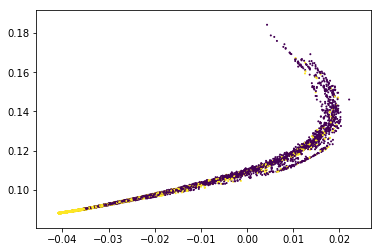

In [86]:
plt.scatter(data_embedding[:,0], data_embedding[:,1], c=y_predicted, s=1, cmap='viridis');